In [45]:
import pandas as pd

customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

### Merging Data

In [46]:
customer_data = pd.merge(customers, transactions, on = "CustomerID")

customer_features = customer_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count'
}).reset_index()
customer_features.columns = ['CustomerID', 'TotalSpending', 'NumTransactions']

### Normalizing Data

In [47]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
customer_features_scaled = customer_features.copy()
customer_features_scaled[['TotalSpending', 'NumTransactions']] = scaler.fit_transform(
    customer_features[['TotalSpending', 'NumTransactions']])

## KMeans Clustering Algorithm & Metrics

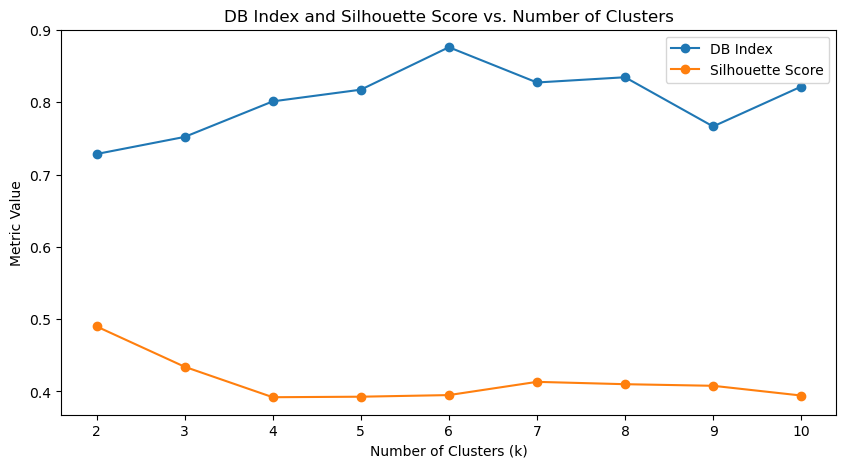

Optimal number of clusters (k): 2


In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

db_index_scores = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_features_scaled.iloc[:, 1:])
    labels = kmeans.labels_
    db_index = davies_bouldin_score(customer_features_scaled.iloc[:, 1:], labels)
    silhouette_avg = silhouette_score(customer_features_scaled.iloc[:, 1:], labels)
    db_index_scores.append((k, db_index))
    silhouette_scores.append((k, silhouette_avg))
    

plt.figure(figsize=(10, 5))
plt.plot([x[0] for x in db_index_scores], [x[1] for x in db_index_scores], marker='o', label='DB Index')
plt.plot([x[0] for x in silhouette_scores], [x[1] for x in silhouette_scores], marker='o', label='Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Metric Value')
plt.title('DB Index and Silhouette Score vs. Number of Clusters')
plt.legend()
plt.show()

optimal_k = min(db_index_scores, key=lambda x: x[1])[0]
print(f"Optimal number of clusters (k): {optimal_k}")

### Fitting Final Model

In [49]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features_scaled['Cluster'] = kmeans.fit_predict(customer_features_scaled.iloc[:, 1:])

### Evaluation Metrics

In [50]:
db_index_final = davies_bouldin_score(customer_features_scaled.iloc[:, 1:-1], customer_features_scaled['Cluster'])
print(f"Davies-Bouldin Index: {db_index_final}")

silhouette_final = silhouette_score(customer_features_scaled.iloc[:, 1:-1], customer_features_scaled['Cluster'])
print(f"Silhouette Score: {silhouette_final}")

print(f"Inertia: {kmeans.inertia_}")

Davies-Bouldin Index: 0.7283881661006848
Silhouette Score: 0.48983356575701203
Inertia: 6.333761552525513


### Cluster Distribution

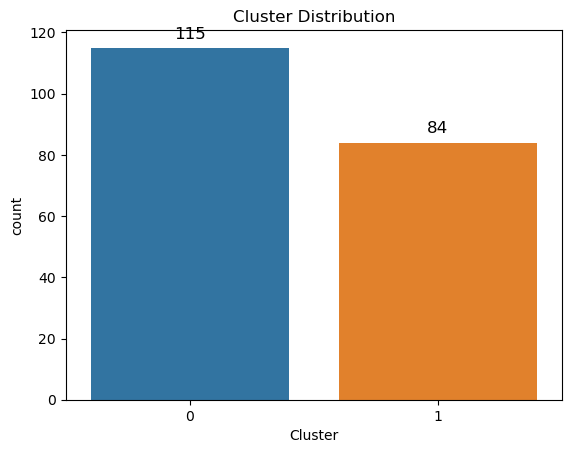

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = sns.countplot(x='Cluster', data=customer_features_scaled)
plt.title('Cluster Distribution')

for p in fig.patches:
    fig.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 10), textcoords='offset points')
plt.show()

### Feature Space Visualization

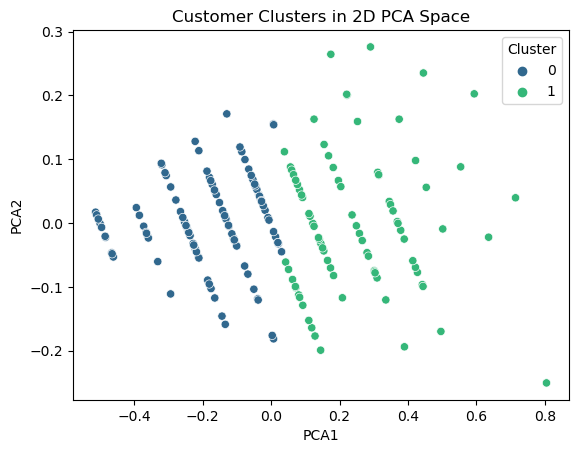

In [52]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(customer_features_scaled.iloc[:, 1:-1])
customer_features_scaled['PCA1'] = pca_features[:, 0]
customer_features_scaled['PCA2'] = pca_features[:, 1]

sns.scatterplot(data=customer_features_scaled, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title('Customer Clusters in 2D PCA Space')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()